In [1]:
!pip install torch torchvision matplotlib scikit-image pillow lpips deepinv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.2/775.2 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.7 MB/s eta 0:00:00


In [2]:
# Block 0: imports, metrics, reproducibility, classical denoisers
import os; os.makedirs("results", exist_ok=True)
import math, numpy as np, torch, torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage import data, restoration, filters, morphology
from PIL import Image
import random

SEED = 12345
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

USE_LPIPS = True
try:
    import lpips
    lpips_fn = lpips.LPIPS(net='alex').eval().to(device) if USE_LPIPS else None
except Exception:
    lpips_fn = None
    print("LPIPS disabled or missing. pip install lpips to enable.")


def load_rgb01():
    from skimage import data
    img = Image.fromarray(data.astronaut())
    x = T.ToTensor()(img).unsqueeze(0)
    return x.to(device)


def psnr(ref, out, eps=1e-12):
    mse = F.mse_loss(out, ref)
    return float(10.0 * torch.log10(1.0 / (mse + eps)))


def lpips_score(ref, out):
    if lpips_fn is None:
        return None
    with torch.no_grad():
        return float(lpips_fn(ref.clamp(0, 1) * 2 - 1, out.clamp(0, 1) * 2 - 1).mean().item())


def to_numpy_img(x):
    return x.detach().cpu().permute(0, 2, 3, 1).numpy()[0]


def to_torch_img(arr, like):
    t = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(like.device, dtype=like.dtype)
    return t.clamp(0, 1)


DRUNET = None


def get_drunet(device):
    global DRUNET
    if DRUNET is not None:
        return DRUNET
    try:
        import deepinv as dinv
        from deepinv.models import DRUNet
        DRUNET = DRUNet(pretrained="download", device=device).eval()
        return DRUNET
    except Exception as e:
        print("DRUNet unavailable. Install: pip install deepinv")
        print("Error:", e)
        return None


def denoise_image(img_np, kind="bilateral", strength=0.1, median_size=3):
    if kind == "median":
        selem = morphology.disk(max(1, int(median_size)))
        out = np.zeros_like(img_np)
        for c in range(img_np.shape[2]):
            out[:, :, c] = filters.median(img_np[:, :, c], footprint=selem)
        return out

    elif kind == "bilateral":
        return restoration.denoise_bilateral(
            img_np,
            sigma_color=float(strength),
            sigma_spatial=3,
            channel_axis=-1
        )

    elif kind == "nlm":
        patch_kw = dict(
            patch_size=3,
            patch_distance=5,
            channel_axis=-1,
            fast_mode=True
        )
        return restoration.denoise_nl_means(img_np, h=float(strength), **patch_kw)

    elif kind == "drunet":
        model = get_drunet(device)
        if model is None:
            return img_np
        x = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float().to(device)
        with torch.no_grad():
            y = model(x, float(strength)).clamp(0, 1)
        return y.squeeze(0).permute(1, 2, 0).cpu().numpy()

    else:
        return img_np


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 198MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


Blur-only PSNR: 22.338279724121094 LPIPS: 0.44099876284599304
Observed PSNR: 21.750185012817383 LPIPS: 0.5156183242797852


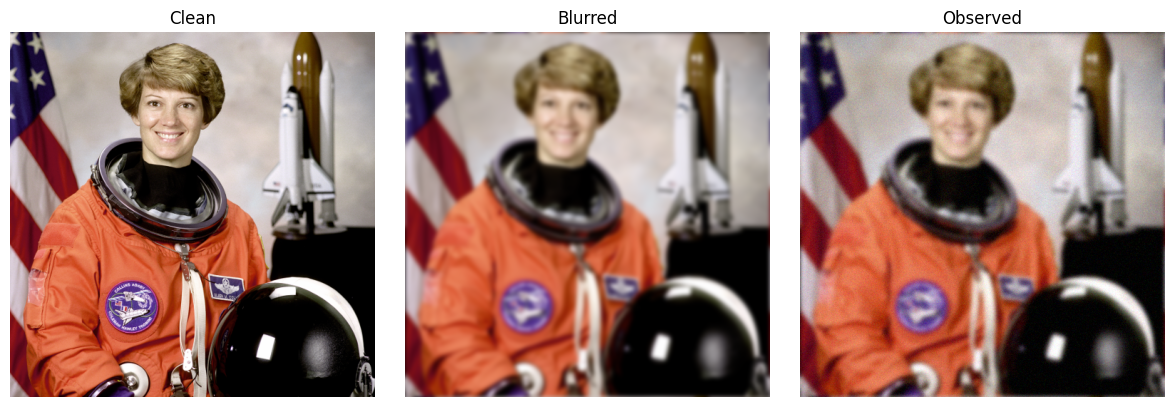

In [3]:
def gaussian_kernel_2d(size=15, std=3.0):
    ax = np.arange(size) - (size - 1) / 2.0
    xx, yy = np.meshgrid(ax, ax)
    k = np.exp(-(xx**2 + yy**2) / (2.0 * std**2))
    k = k / k.sum()
    return k.astype(np.float32)


def convolve_circular(x, kernel_np):
    k = torch.from_numpy(kernel_np).to(x.device, dtype=x.dtype).unsqueeze(0).unsqueeze(0)
    pad = kernel_np.shape[0] // 2
    out = torch.zeros_like(x)
    for c in range(x.shape[1]):
        chp = F.pad(x[:, c:c+1], (pad, pad, pad, pad), mode="circular")
        out[:, c:c+1] = F.conv2d(chp, k, padding=0)
    return out


x_clean = load_rgb01()
k_np = gaussian_kernel_2d(size=15, std=3.0)
xb = convolve_circular(x_clean, k_np)

sigma = 0.03
y = (xb + sigma * torch.randn_like(xb)).clamp(0, 1)

print("Blur-only PSNR:", psnr(x_clean, xb), "LPIPS:", lpips_score(x_clean, xb))
print("Observed PSNR:", psnr(x_clean, y), "LPIPS:", lpips_score(x_clean, y))

# Display images
imgs = [to_numpy_img(x_clean), to_numpy_img(xb), to_numpy_img(y)]
titles = ["Clean", "Blurred", "Observed"]

plt.figure(figsize=(12, 4))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ======================================================
# FFT utilities
# ======================================================

def psf_fft(kernel_np, shape_hw, device):
    hk, wk = kernel_np.shape
    H, W = shape_hw
    pad = torch.zeros((H, W), dtype=torch.float32, device=device)
    pad[:hk, :wk] = torch.from_numpy(kernel_np).to(device)
    pad = torch.roll(pad, shifts=(-hk // 2, -wk // 2), dims=(0, 1))
    return torch.fft.fft2(pad)


B, C, H, W = y.shape
Kf = psf_fft(k_np, (H, W), device)
Yf = torch.fft.fft2(y)
Hty_f = torch.conj(Kf) * Yf

# ======================================================
# PARAMETERS
# ======================================================

denoisers = ["median", "bilateral", "nlm", "drunet"]
rhos = [0.1, 0.3, 1.0]        # ADMM regularization weights
taus = [0.5, 1.0]             # FB step sizes
strengths = [0.02, 0.05, 0.1] # Denoising strengths
iters_admm = 50
iters_fb = 50
tol = 1e-4
patience = 5

# ======================================================
# PnP-ADMM
# ======================================================

def run_pnp_admm(kind, rho, strength, iters_admm=50, tol=1e-4, patience=5):
    denom = (torch.abs(Kf) ** 2 + rho)
    x = y.clone()
    z = y.clone()
    u = torch.zeros_like(y)
    psnr_hist = []
    stop_counter = 0

    for t in range(1, iters_admm + 1):
        rhs_f = Hty_f + rho * torch.fft.fft2(z - u)
        x = torch.real(torch.fft.ifft2(rhs_f / denom)).clamp(0, 1)
        x_plus_u = (x + u).clamp(0, 1)

        den_np = denoise_image(to_numpy_img(x_plus_u), kind=kind,
                               strength=strength, median_size=3)
        z_new = to_torch_img(den_np, x_plus_u)
        z = z_new
        u = u + x - z
        psnr_hist.append(psnr(x_clean, x))

        # Early stopping
        if len(psnr_hist) > 1:
            delta = psnr_hist[-1] - psnr_hist[-2]
            if delta < tol:
                stop_counter += 1
                if stop_counter >= patience:
                    break
            else:
                stop_counter = 0

    return x, psnr_hist, psnr(x_clean, x), lpips_score(x_clean, x)

# ======================================================
# PnP-FB
# ======================================================

def run_pnp_fb(kind, tau, strength, iters_fb=50, tol=1e-4, patience=5):
    x_fb = y.clone()
    psnr_hist = []
    stop_counter = 0

    for t in range(iters_fb):
        grad = convolve_circular(convolve_circular(x_fb, k_np) - y, k_np)
        v = (x_fb - tau * grad).clamp(0, 1)
        den_np = denoise_image(to_numpy_img(v), kind=kind,
                               strength=strength, median_size=3)
        x_fb = to_torch_img(den_np, v)
        psnr_hist.append(psnr(x_clean, x_fb))

        # Early stopping
        if len(psnr_hist) > 1:
            delta = psnr_hist[-1] - psnr_hist[-2]
            if delta < tol:
                stop_counter += 1
                if stop_counter >= patience:
                    break
            else:
                stop_counter = 0

    return x_fb, psnr_hist, psnr(x_clean, x_fb), lpips_score(x_clean, x_fb)

# ======================================================
# MAIN SWEEP
# ======================================================

results_admm = []
results_fb = []

for kind in denoisers:
    print(f"\n=== {kind.upper()} ===")

    # Sweep ρ (ADMM)
    print("\n--- PnP-ADMM Sweep ---")
    for strength in strengths:
        for rho in rhos:
            x_out, psnr_hist, psnr_final, lpips_final = run_pnp_admm(kind, rho, strength)
            results_admm.append((kind, rho, strength, psnr_final, lpips_final))
            print(f"ρ={rho:<4} | strength={strength:<4} → PSNR={psnr_final:.2f}, LPIPS={lpips_final:.3f}")

            # Plot PSNR curve
            plt.figure()
            plt.plot(psnr_hist)
            plt.xlabel("Iteration")
            plt.ylabel("PSNR")
            plt.title(f"PnP-ADMM ({kind}) ρ={rho}, s={strength}")
            plt.tight_layout()
            plt.show()

            # Show result
            imgs = [to_numpy_img(x_clean), to_numpy_img(y), to_numpy_img(x_out)]
            titles = ["Clean", "Observed (Blur+Noise)", f"PnP-ADMM ({kind}, ρ={rho}, s={strength})"]
            plt.figure(figsize=(12, 4))
            for i, (img, title) in enumerate(zip(imgs, titles)):
                plt.subplot(1, 3, i + 1)
                plt.imshow(img)
                plt.title(title)
                plt.axis("off")
            plt.tight_layout()
            plt.show()

    # Sweep τ (FB)
    print("\n--- PnP-FB Sweep ---")
    for strength in strengths:
        for tau in taus:
            x_out, psnr_hist, psnr_final, lpips_final = run_pnp_fb(kind, tau, strength)
            results_fb.append((kind, tau, strength, psnr_final, lpips_final))
            print(f"τ={tau:<4} | strength={strength:<4} → PSNR={psnr_final:.2f}, LPIPS={lpips_final:.3f}")

            # Plot PSNR curve
            plt.figure()
            plt.plot(psnr_hist)
            plt.xlabel("Iteration")
            plt.ylabel("PSNR")
            plt.title(f"PnP-FB ({kind}) τ={tau}, s={strength}")
            plt.tight_layout()
            plt.show()

            # Show result
            imgs = [to_numpy_img(x_clean), to_numpy_img(y), to_numpy_img(x_out)]
            titles = ["Clean", "Observed (Blur+Noise)", f"PnP-FB ({kind}, τ={tau}, s={strength})"]
            plt.figure(figsize=(12, 4))
            for i, (img, title) in enumerate(zip(imgs, titles)):
                plt.subplot(1, 3, i + 1)
                plt.imshow(img)
                plt.title(title)
                plt.axis("off")
            plt.tight_layout()
            plt.show()

# ======================================================
# SUMMARIZE RESULTS
# ======================================================

df_admm = pd.DataFrame(results_admm, columns=["denoiser", "rho", "strength", "PSNR", "LPIPS"])
df_fb = pd.DataFrame(results_fb, columns=["denoiser", "tau", "strength", "PSNR", "LPIPS"])

print("\n=== Recommended ρ (ADMM) per denoiser ===")
print(df_admm.sort_values(["denoiser", "LPIPS", "rho"]).groupby("denoiser").first()[["rho", "strength", "PSNR", "LPIPS"]])

print("\n=== Recommended τ (FB) per denoiser ===")
print(df_fb.sort_values(["denoiser", "LPIPS", "tau"]).groupby("denoiser").first()[["tau", "strength", "PSNR", "LPIPS"]])

# ======================================================
# OPTIONAL: PSNR vs PARAMETER PLOTS
# ======================================================

for kind in denoisers:
    subset = df_admm[df_admm["denoiser"] == kind]
    plt.figure()
    for s in strengths:
        sub_s = subset[subset["strength"] == s]
        plt.plot(sub_s["rho"], sub_s["PSNR"], marker="o", label=f"s={s}")
    plt.xscale("log")
    plt.title(f"PnP-ADMM ({kind}) – PSNR vs ρ")
    plt.xlabel("ρ")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()

for kind in denoisers:
    subset = df_fb[df_fb["denoiser"] == kind]
    plt.figure()
    for s in strengths:
        sub_s = subset[subset["strength"] == s]
        plt.plot(sub_s["tau"], sub_s["PSNR"], marker="o", label=f"s={s}")
    plt.title(f"PnP-FB ({kind}) – PSNR vs τ")
    plt.xlabel("τ")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [7]:
# --- Print full results tables ---
print("\n=== Full PnP-ADMM Results ===")
print(df_admm.sort_values(["denoiser", "rho", "strength"]).to_string(index=False))

print("\n=== Full PnP-FB Results ===")
print(df_fb.sort_values(["denoiser", "tau", "strength"]).to_string(index=False))



=== Full PnP-ADMM Results ===
 denoiser  rho  strength      PSNR    LPIPS
bilateral  0.1      0.02 22.231350 0.322871
bilateral  0.1      0.05 21.407568 0.301471
bilateral  0.1      0.10 21.017902 0.325733
bilateral  0.3      0.02 22.060490 0.352194
bilateral  0.3      0.05 21.195612 0.328864
bilateral  0.3      0.10 20.682928 0.366113
bilateral  1.0      0.02 21.831097 0.395724
bilateral  1.0      0.05 20.787668 0.379378
bilateral  1.0      0.10 20.035671 0.429114
   drunet  0.1      0.02 22.843529 0.439361
   drunet  0.1      0.05 23.107283 0.290176
   drunet  0.1      0.10 23.141451 0.287936
   drunet  0.3      0.02 22.988396 0.351970
   drunet  0.3      0.05 23.114717 0.285994
   drunet  0.3      0.10 23.070030 0.308431
   drunet  1.0      0.02 22.953176 0.318098
   drunet  1.0      0.05 23.000422 0.307225
   drunet  1.0      0.10 22.821024 0.337468
   median  0.1      0.02 22.915642 0.302630
   median  0.1      0.05 22.915642 0.302630
   median  0.1      0.10 22.915642 0.302630
 